# All imports

In [0]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

import pandas as pd
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix,lil_matrix

In [0]:
%matplotlib inline
sns.set_style('darkgrid')

# Load data

In [7]:
if not os.path.exists('./data'):
  os.mkdir('./data')

gdd.download_file_from_google_drive(file_id='1r6U_EFULKXiuLPrIEAdoJ7W_1Xa7aJ3Q', dest_path='./data/movies.zip')

In [8]:
! unzip ./data/movies.zip -d ./data/unziped

Archive:  ./data/movies.zip
  inflating: ./data/unziped/links.csv  
  inflating: ./data/unziped/movies.csv  
  inflating: ./data/unziped/ratings.csv  
  inflating: ./data/unziped/tags.csv  
  inflating: ./data/unziped/u.data   


# EDA

This table contains all info about user - movie interaction by ratings.

In [11]:
ratings_df = pd.read_csv('./data/unziped/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [12]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId       100004 non-null int64
movieId      100004 non-null int64
rating       100004 non-null float64
timestamp    100004 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Luckily no nans

In [13]:
ratings_df.isnull().values.any()

False

Total number of users

In [14]:
ratings_df['userId'].nunique()

671

Total number of ratings is:

In [15]:
ratings_df.shape[0]

100004

Total number of movies is:

In [17]:
ratings_df['movieId'].nunique()

9066

Al least 20 ratings were made by one user. Very active user made 2391 ratings.

In [18]:
ratings_df.groupby('userId').agg({'rating' : 'count'}).describe()

,rating
count,671.000000
mean,149.037258
std,231.226948
min,20.000000
25%,37.000000
50%,71.000000
75%,161.000000
max,2391.000000


Text(0.5, 0, 'number of ratings')

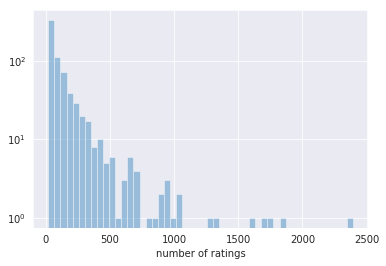

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.distplot(ratings_df.groupby('userId').agg({'rating' : 'count'}).values, ax=ax, kde=False)
ax.set_yscale('log')
ax.set_xlabel("number of ratings")

Ratings distribution

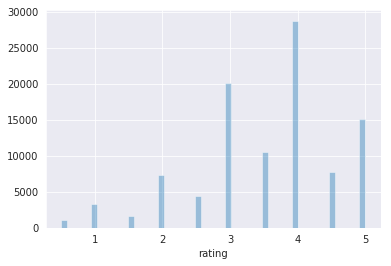

In [20]:
sns.distplot(ratings_df['rating'],kde=False)

We can see that ratings are ordinal, not numerical. 

Our user - item interaction matrix is very sparse. Less than a 2 percents of all cells are filled.

In [22]:
ratings_df.shape[0] / (ratings_df['userId'].nunique() * ratings_df['movieId'].nunique())

0.016439141608663475

In [23]:
tags_df = pd.read_csv('./data/unziped/tags.csv')
tags_df.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


Luckily no nans

In [24]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 4 columns):
userId       1296 non-null int64
movieId      1296 non-null int64
tag          1296 non-null object
timestamp    1296 non-null int64
dtypes: int64(3), object(1)
memory usage: 40.6+ KB


Total number of tags

In [26]:
tags_df['tag'].nunique()

582

Extremly active user added 20356 tags

In [27]:
tags_df.groupby('userId').agg({'tag':'count'}).describe()

,tag
count,61.000000
mean,21.245902
std,58.614462
min,1.000000
25%,2.000000
50%,4.000000
75%,9.000000
max,401.000000


Text(0.5, 0, 'number of tags')

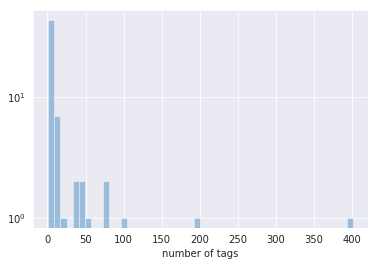

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.distplot(tags_df.groupby('userId').agg({'tag' : 'count'}).values, ax=ax, kde=False)
ax.set_yscale('log')
ax.set_xlabel("number of tags")

# Evaluation metrics implementation

In [0]:
def precision_at_k(predicted, actual, k):
  assert len(predicted) >= k
  intersection = set(predicted[:k]) & set(actual)
  return len(intersection) / min(k,len(actual))

In [0]:
def average_precision(predicted, actual):
  tmp = 0
  actual_length = len(predicted)
  for i in range(actual_length):
    if predicted[i] in actual:
      tmp += precision_at_k(predicted[:i+1], actual, i+1)
  return tmp / actual_length

In [0]:
def mean_average_precision(predicted_list, actual_list):
  tmp = 0
  cnt = 0
  for predicted, actual in zip(predicted_list, actual_list):
    if len(actual) != 0:
      tmp += average_precision(predicted, actual)
      cnt += 1
  assert cnt != 0
  return tmp / cnt
    

In [0]:
def reciprocal_rank(predicted, actual):
  pass

In [0]:
predicted = [1,3,5,2,13,9,10,17]
actual = [1,3,2,5,4,8,9,10]


In [0]:
predicted = [1,30,23,67]
actual = [1,30,23,67]

In [0]:
precision_at_k(predicted, actual, k=1)

1.0

In [0]:
average_precision(predicted, actual)

0.2

In [0]:
mean_average_precision([predicted, predicted], [actual, actual])

0.2

In [0]:
percentage_ranking(predicted, actual)

0.625

In [0]:
predicted=[1,2,3,4]
actual = [1,2,5,3]

In [12]:
average_precision(predicted, actual)

0.75

In [18]:
apk(actual,predicted,k=4)

0.75

# Collaborative filtering recommenders

In [0]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'])

In [33]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1970-01-01 00:00:01.260759144
1,1,1029,3.0,1970-01-01 00:00:01.260759179
2,1,1061,3.0,1970-01-01 00:00:01.260759182
3,1,1129,2.0,1970-01-01 00:00:01.260759185
4,1,1172,4.0,1970-01-01 00:00:01.260759205


Relevance binarization

In [0]:
ratings_df['relevance'] = ratings_df['rating'].apply(lambda x: 1 if x >= 3 else 0)

Ground truth pairs have 1 relevance.

## TO DO: IMPROVE SPLIT


In this dataset time separates users in non intersected sets!!!!!!

In [0]:
##CAN'T MAKE ONE SIMPLE TRAIN TEST SPLIT!!!!!
tscv = TimeSeriesSplit(n_splits=2)
X_train, X_test, y_train, y_test = None, None, None, None
for train_index, test_index in tscv.split(ratings_df):
  X_train, X_test = ratings_df.loc[train_index,['userId', 'movieId']], ratings_df.loc[test_index, ['userId', 'movieId']]
  relevance_train, relevance_test = ratings_df.loc[train_index, 'relevance'], ratings_df.loc[test_index, 'relevance']

## Most popular recommender

In [0]:
class MostPopularRecommender():
  def __init__(self, top_n=5):
    self.top_n = top_n
  
  def fit(self, X_train, y_train):
    assert type(X_train) == pd.DataFrame
    X_train['relevance'] = y_train
    self.most_popular = list(X_train.groupby('movieId').agg({'relevance' : 'sum'}).sort_values(by='relevance', ascending=False)[:self.top_n].index)
  
  def predict(self, X_test):
    recommendation_list = []
    for user in X_test['userId'].unique():
      recommendation_list.append(self.most_popular)
    return recommendation_list 

In [0]:
most_popular_recommender = MostPopularRecommender(top_n=10)
most_popular_recommender.fit(X_train, relevance_train)
predicted_all_users_list = most_popular_recommender.predict(X_test)

In [0]:
X_test['relevance'] = relevance_test
grouped_by_user = X_test.groupby('userId')
test_all_users_list = []
for user in X_test['userId'].unique():
  group = grouped_by_user.get_group(user)
  user_list = list(group.loc[group['relevance']==1,'movieId'].values)
  test_all_users_list.append(user_list)

In [39]:
mean_average_precision(predicted_all_users_list, test_all_users_list)

0.29698354341736694

## SVD recommender

On full dataset

In [0]:
R_df = ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)

In [53]:
R = R_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 10)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)

In [0]:
grouped_by_user = ratings_df.groupby('userId')
test_all_users_list = []
for user in ratings_df['userId'].unique():
  group = grouped_by_user.get_group(user)
  user_list = list(group.loc[group['rating']>=3,'movieId'].values)
  test_all_users_list.append(user_list)


In [0]:
predicted_all_users_list = []
for user in ratings_df['userId'].unique():
  user_row_number = user-1
  predicted_all_users_list.append(list(preds_df.iloc[user_row_number].sort_values(ascending=False).index[:10]))

In [57]:
mean_average_precision(predicted_all_users_list, test_all_users_list)

0.5191256830601093

with split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test = train_test_split(ratings_df.loc[:,['userId', 'movieId', 'rating']], test_size=0.33, random_state=42)

In [0]:
##CAN'T MAKE ONE SIMPLE TRAIN TEST SPLIT!!!!!
'''tscv = TimeSeriesSplit(n_splits=2)
X_train, X_test = None, None
for train_index, test_index in tscv.split(ratings_df):
  X_train, X_test = ratings_df.loc[train_index,['userId', 'movieId', 'rating']], ratings_df.loc[test_index, ['userId', 'movieId', 'rating']]
  #relevance_train, relevance_test = ratings_df.loc[train_index, 'relevance'], ratings_df.loc[test_index, 'relevance']'''

In [96]:
R_df = X_train.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
R = R_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 4)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.index = R_df.index

In [0]:
grouped_by_user = X_test.groupby('userId')
test_all_users_list = []
for user in X_test['userId'].unique():
  if user in X_train['userId'].unique():
    group = grouped_by_user.get_group(user)
    user_list = list(group.loc[group['rating']>=3,'movieId'].values)
    test_all_users_list.append(user_list)


In [0]:
predicted_all_users_list = []
for user in X_test['userId'].unique():
  if user in X_train['userId'].unique():
     user_row_number = user
     predicted_all_users_list.append(list(preds_df.loc[user_row_number].sort_values(ascending=False).index[:5]))
   

In [94]:
len(test_all_users_list)

671

In [86]:
len(predicted_all_users_list)

671

In [88]:
len(set(X_train['userId'].unique()) & set(X_test['userId'].unique()))

671

In [102]:
mean_average_precision(predicted_all_users_list, test_all_users_list)

0.09104321907600614